# 6章 学習に関するテクニック

本章で取り上げること：
* 最適な重みパラメータを探索するための最適化手法
* 重みパラメータの初期値
* ハイパーパラメータの設定方法
* 過学習の対応策としての正規化手法
  * Weight decay
  * Dropout
  * Batch Normalization

## 6.1 パラメータの更新

* ニューラルネットワークの学習は最適化(optimization)問題
  * 損失関数の値をできるだけ小さくするパラメータを見つける
  * パラメータ空間は非常に複雑であり，とても難しい問題
    * ディープなネットワークではパラメータ数が膨大になるため，さらに難しい

* これまでの手法：確率的勾配降下法(stochastic gradient decent, SGD)
  * 単純な方法．闇雲に探すよりは賢いが，もっとスマートな方法もある

### 6.1.1 冒険家の話（省略）

### 6.1.2 SGD
おさらい：SGDは次のように記述できる．
* ただし，重みパラメータを${\bf W}$，損失関数の勾配を$\frac{\partial L}{\partial {\bf W}}$，学習係数を$\eta$とする．
* また，$\leftarrow$は右辺の値で左辺を更新するということを表す．
* つまり，SGDは勾配方向へ一定の距離だけ進むという方法である．

$${\bf W}\leftarrow {\bf W}-\eta\frac{\partial L}{\partial {\bf W}}$$

最適化を行うクラスとしてSGDをPythonのクラスとして実装してみる．
* 最適化をクラスとして分離することで，機能をモジュール化することができる．

In [86]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
sys.path.append(os.pardir + "/deep_learning_from_scratch")


In [3]:
# 最適化を実施するためのクラス．
# 確率的勾配降下法(SGD)を用いて値を更新する
class SGD:
    # lr: 学習係数
    def __init__(self, lr=0.01):
        self.lr = lr
    
    # 値の更新．学習の際は繰り返し呼び出される
    # params: パラメータ(ディクショナリ)．params['W1'] のように使う
    # grads: 勾配(ディクショナリ)
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


### 6.1.3 SGDの欠点
* SGDは単純だが，問題によっては非効率な場合がある
* 次の関数の最小を求める問題を考えてみる：$f(x,y)=\frac{1}{20}x^2+y^2$

In [50]:
# 勾配計算の実装
# f: 関数，　x：　パラメータ（配列）
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.shape[0]):
        # 元の値を一時退避
        tmp_val = x[idx]
        
        # f(x+h) の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        #　勾配の算出（中心差分）
        grad[idx] = (fxh1 - fxh2) / (2 * h)
                
        # 退避していた値を戻す
        x[idx] = tmp_val  
    return grad

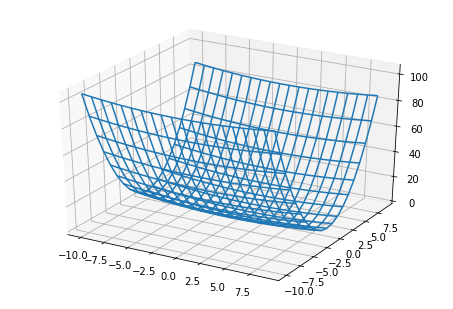

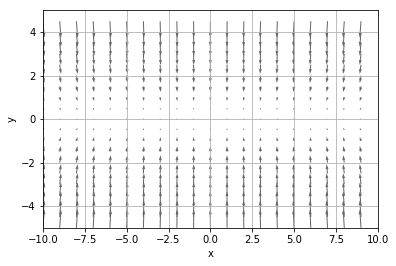

In [63]:
def function_1(x):
    return (x[0]**2)/20 + x[1]**2

# function_1 をグラフに描画する
x = [np.arange(-10, 10, 1), np.arange(-10, 10, 1)]
X, Y = np.meshgrid(x[0], x[1])
Z = function_1([X, Y])

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,Z)

plt.show()

# 勾配をグラフに図示
x0 = np.arange(-10, 10, 1)
x1 = np.arange(-5, 5, 0.5)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_1, np.array([X, Y]))
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")

plt.xlim([-10, 10])
plt.ylim([-5, 5])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.draw()
plt.show()

グラフから分かること
* y軸方向は勾配が大きく，x軸方向は小さい（緩やか）
* 最小値は(0,0)だが，多くの点における勾配がこの方向を向いていない
  * **探索が非効率になる本質的な要因**

In [73]:
# 関数のSGDによる最適化過程を示すコードをここに追加する
# 初期値は (x,y)=(-7.0, 2.0)から開始する

### 6.1.4 Momentum
* 以下のように定式化される
  * ${\bf W}$：更新対象の重みパラメータ
  * $\frac{\partial L}{\partial {\bf W}}$：${\bf W}$に関する損失関数の勾配
  * $\eta$：学習係数
$${\bf v}\leftarrow \alpha{\bf v}-\eta\frac{\partial L}{\partial {\bf W}}$$
$${\bf W}\leftarrow {\bf W}+{\bf v}$$
* Momentumとは「運動量」という意味
* 新たに${\bf v}$という変数が導入される．物理でいうところの「速度」に相当する．
* 物体が勾配方向に力を受け，その力によって物体の速度が加算されるという物理法則を表す
* $\alpha {\bf v}$という項は物体が何も力を受けないときに徐々に減速するための役割を担う．摩擦抵抗や空気抵抗のようなもの．

In [76]:
class Momentum:
    # v は物体の速度を保持するインスタンス変数（初期化時には何も保持しない）
    def __init__(self, lr=0.01, moment=0.9):
        self.lr = lr
        self.moment = moment
        self.v = None
    
    def update(self, params, grads):
        # 初回呼び出し時，vはパラメータと同じ構造のデータをディクショナリ変数として保持する
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.moment*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]


In [ ]:
# Momentum を使って最適化問題を解いてみる


### 6.1.5 AdaGrad
* ニューラルネットの学習では学習係数の値が重要になる．
* 学習係数に関するテクニックとして学習係数の減衰(learning rate decay)という方法があり，AdaGradはさらにそれを発展させたもの
  * 学習が進むにつれて学習係数を小さくするということ
  * AdaGradでは，パラメータ一つ一つに対して適応的に学習係数を調整しながら学習を行う
* AdaGradは以下のように定式化される
  * ${\bf W}$：重みパラメータ
  * $\frac{\partial L}{\partial {\bf W}}$：${\bf W}$に関する損失関数の勾配
  * $\eta$：学習係数
  * ${\bf h}$：これまでに経験した勾配値の2乗和($\odot$は行列の要素ごとの掛け算を表す)
    * パラメータ更新の際，$\frac{1}{\sqrt{{\bf h}}}$を乗算することで学習のスケールを調整する
    * 大きく動いた変数ほど学習係数が小さくなる
    * 過去のすべての勾配の2乗和が加算されるため，更新量はどんどん0に近く（全く動かなくなる）
    * RMSPropという方法では，「指数移動平均」により指数関数的に過去の勾配のスケールを減少させることでこの問題を解決している
$${\bf h}\leftarrow{\bf h}+\frac{\partial L}{\partial {\bf W}}\odot \frac{\partial L}{\partial {\bf W}}　\\
{\bf W}\leftarrow{\bf W}-\eta\frac{1}{\sqrt{{\bf h}}}\frac{\partial L}{\partial {\bf W}}$$

In [74]:
# AdaGradの実装
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            # 1e-7という小さい値を加算することでself.h[key]の中に0があった場合のゼロ割を回避する
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.6 Adam
* Momentum と Adam との融合をベースとした手法
* ハイパーパラメータのバイアス補正が行われるという特徴がある
* (参考)[論文「ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION」](https://arxiv.org/pdf/1412.6980.pdf)

In [71]:
# Adam の実装（common/optimizer.pyより）
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


### 6.1.7 どの更新手法を用いるか？

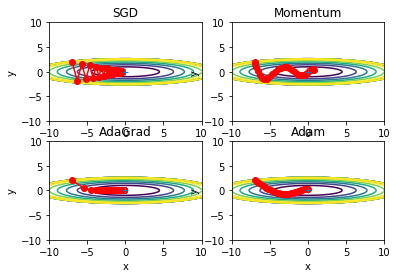

In [77]:
from collections import OrderedDict

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### 6.1.8 MNISTデータセットによる更新手法の比較
* 手書き文字認識を対象に，これまでの4つの手法を比較し，学習の進み具合の違いを確認する
* 分かること：
  * SGDよりもそれ以外の手法が速く学習できている
  * SGD以外の手法ではAdaGradが少しだけ速いが，ハイパーパラメータやニューラルネットワークの構造により結果は変わり得る

===========iteration:0===========
SGD:2.43392039213
Momentum:2.40027211431
AdaGrad:2.02317872055
Adam:2.18937513276
===========iteration:100===========
SGD:1.44713808717
Momentum:0.430010148591
AdaGrad:0.201473715236
Adam:0.33248504116
===========iteration:200===========
SGD:0.698456116107
Momentum:0.204916914098
AdaGrad:0.0809346754347
Adam:0.143768540908
===========iteration:300===========
SGD:0.473722155579
Momentum:0.195940751229
AdaGrad:0.0735133391994
Adam:0.180187111377
===========iteration:400===========
SGD:0.506437922901
Momentum:0.163406313275
AdaGrad:0.0772966429775
Adam:0.12165763959
===========iteration:500===========
SGD:0.356481213731
Momentum:0.180423874807
AdaGrad:0.116375476783
Adam:0.147889864108
===========iteration:600===========
SGD:0.32268757108
Momentum:0.14783135872
AdaGrad:0.0513308005988
Adam:0.156815933131
===========iteration:700===========
SGD:0.298921319604
Momentum:0.102333513163
AdaGrad:0.0385366904842
Adam:0.0894942735362
===========iteration:800=====

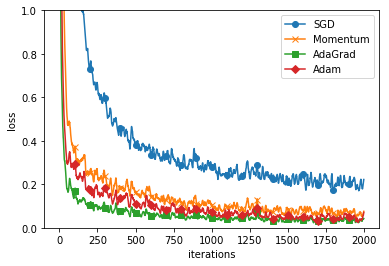

In [115]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()



## 6.2 重みの初期値
* 学習では重みパラメータの初期値は重要
  * 値により，成否が分かれることもある
* 推奨される初期値とは？

### 6.2.1 重みの初期値を0にする？
#### Weight decay
* 重みパラメータの値が小さくなるように学習を行うための手法．過学習が起きにくくなる．
* 重みの初期値をすべて0にするのは悪い方法．正しい学習が行えない
  * 正確には，重みを均一な値に設定してはいけない
  * (理由)誤差逆伝播法において，すべての重みの値が同じように更新されてしまい，重みを持つ意味がなくなる
  * そのため，過去のサンプルではランダムな初期値を与えていた

### 6.2.2 隠れ層のアクティベーション分布
* 隠れ層のアクティベーション（活性化関数を通した後の出力）の分布を観察してみる
  * ここでは，重みの初期値により隠れ層のアクティベーションがどのように変化するかを見てみる

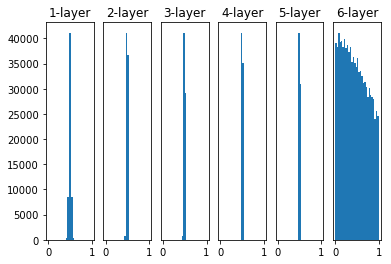

In [113]:
# 5層のニューラルネットワークにランダムな入力を流し，各層のアクティベーションのデータ分布をヒストグラムで描画する
# 活性化関数としてシグモイド関数，ReLU関数，双曲線関数(tanh)を使用する

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここに各層のアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    # 重みの初期値の値をいろいろ変えて実験しよう！
    ## 標準偏差が1の標準偏差
    #w = np.random.randn(node_num, node_num) * 1
    ## 標準偏差が0.01の標準偏差
    w = np.random.randn(node_num, node_num) * 0.01
    ## Xavierの初期値($\sqrt{\frac{1}{n}}$を標準偏差とするガウス分布)
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    ## Heの初期値($\sqrt{\frac{2}{n}}$を標準偏差とするガウス分布)
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    
    a = np.dot(x, w)
    
    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    #z = ReLU(a)
    #z = tanh(a)
    
    activations[i] = z

activations[i+1] = input_data

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()



#### 出力の考察
* 1を標準偏差とするガウス分布の場合
  * シグモイド関数の0と1における微分の値は共に0に近くことから，データ分布が0と1に偏っていると各層のアクティベーションは0と1に偏った分布になる．
  * 結果として，逆伝播での勾配値はどんどん小さくなる（**勾配消失(gradient vanishing)**という）
  * 層を深くするとさらに深刻になる
* 0.01を標準偏差とするガウス分布の場合
  * 中央(0.5)付近に集中する分布になる
  * 勾配の値が0にならないので勾配消失は生じない
  * 出力に差が出ていないため，ニューロンが複数存在する意味がなくなっている
* **効率的な学習のためには，各層のアクティベーションは適度に広がりをもつ分布であることが望ましい**

#### Xaviarの初期値

* [Xavier Glorotらの論文](http://proceedings.mlr.press/v9/glorot10a.html)で推奨される，重みの初期値
* 前層のノード個数を$n$とした場合に，$\sqrt{\frac{1}{n}}$を標準偏差とするガウス分布を用いる
* この初期値を用いると，広がりを持った分布になっていることが確認できる

### 6.2.3 ReLUの場合の重みの初期値
* 活性化関数がシグモイド関数の場合，Xavierの初期値を用いる($\sqrt{\frac{1}{n}}$を標準偏差とするガウス分布)
  * 本来，Xavierの初期値は活性化関数が線形関数であることを前提に導かれたものだが，中央付近が線形関数に近似できるとみなせるため使用している
* 活性化関数がReLU関数の場合，Heの初期値を用いる($\sqrt{\frac{2}{n}}$を標準偏差とするガウス分布)
  * （直感的には）負の領域が0になるために係数に広がりを持たせる必要があると考えられる

### 6.2.4 MNISTデータセットによる重み初期値の比較

===========iteration:0===========
std=0.01:2.30247235257
Xavier:2.30123128342
He:2.39112844
===========iteration:100===========
std=0.01:2.30269588029
Xavier:2.2262128909
He:1.47229197647
===========iteration:200===========
std=0.01:2.30099707576
Xavier:2.09844149388
He:0.748945832167
===========iteration:300===========
std=0.01:2.30356621539
Xavier:1.85446774014
He:0.629758601156
===========iteration:400===========
std=0.01:2.30111983745
Xavier:1.36846513771
He:0.33002066809
===========iteration:500===========
std=0.01:2.30195618758
Xavier:0.947531996493
He:0.36181230802
===========iteration:600===========
std=0.01:2.30164815493
Xavier:0.645007415553
He:0.224861334764
===========iteration:700===========
std=0.01:2.30044650154
Xavier:0.659812657603
He:0.391263752847
===========iteration:800===========
std=0.01:2.30019986889
Xavier:0.435522699742
He:0.292596364621
===========iteration:900===========
std=0.01:2.30279785973
Xavier:0.435873394256
He:0.231563636375
===========iteration:1000

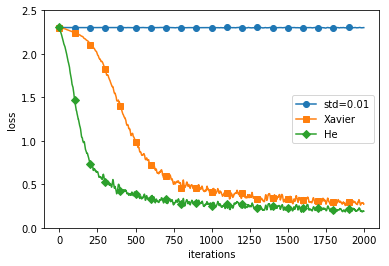

In [116]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

#### 出力のまとめ
* 0.01を標準偏差とするガウス分布は全く学習が進んでいない
* XavierおよびHeのいずれの場合も学習は進んでいる．Heの初期値の方が学習が速い．
* 重みの初期値の設定は学習の成否を分ける重要なポイントであることが確認できた

## 6.3 Batch Normalization
* 前節では，各層のアクティベーションの分布を観察し，適切な重みの初期値の設定によりアクティベーションの分布は適度な広がりを持ち，学習がスムーズに進むことを確認した
* [Batch Normalization](https://arxiv.org/abs/1502.03167) とは，各層で適度な広がりを持つように「強制的」にアクティベーションの分布を調整する手法

### 6.3.1 Batch Normalization のアルゴリズム
* Batch Normが注目されている理由
  * 学習を速く進行させることができる（学習係数を大きくできる）
  * 初期値にそれほど依存しない(初期値に神経質にならなくて良い）
  * 過学習を抑制する(Dropoutなどの必要性を減らす)

#### 手順
* AffineレイヤとReLUレイヤとの間にBatch Normレイヤを挿入する
* Batch Normでは，ミニバッチ単位で正規化処理を行う．具体的にはデータ分布が平均0，分散1になるようにする
  1. ミニバッチとして，$B=\{x_1, x_2,...,x_m\}$という$m$個の入力データの集合に対する平均$\mu_B$，分散$\sigma^2_B$を求める
  2. 入力データを平均が0で分散が1になるように正規化する
    * 下記の式で，$\epsilon$は小さい値(例えば 10e-7など)を示す（ゼロ割防止のため）
$$\mu_B\leftarrow \frac{1}{m}\sum^{m}_{i=1}x_i \\
\sigma^2_B\leftarrow \frac{1}{m}\sum^{m}_{i=1}(x_i-\mu_B)^2 \\
\hat{x_i}\leftarrow \frac{x_i-\mu_B}{\sqrt{\sigma^2_B+\epsilon}}$$
  3. 正規化されたデータに対し，固有のスケールとシフトで変換を行う
$$y_i\leftarrow \gamma \hat{x_i}+\beta$$
    * ここで$\gamma$と$\beta$はパラメータ．最初は$(\gamma,\beta)=(1,0)$からスタートし，学習により値が調整される．

#### Batch Normの逆伝播の導出（省略）

### 6.3.2 Batch Normalization の評価



============== 1/16 ==============
epoch:0 | 0.099 - 0.149


../deep_learning_from_scratch/common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
../deep_learning_from_scratch/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
../deep_learning_from_scratch/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:1 | 0.097 - 0.103
epoch:2 | 0.097 - 0.14
epoch:3 | 0.097 - 0.162
epoch:4 | 0.097 - 0.178
epoch:5 | 0.097 - 0.2
epoch:6 | 0.097 - 0.212
epoch:7 | 0.097 - 0.233
epoch:8 | 0.097 - 0.257
epoch:9 | 0.097 - 0.291
epoch:10 | 0.097 - 0.287
epoch:11 | 0.097 - 0.321
epoch:12 | 0.097 - 0.338
epoch:13 | 0.097 - 0.356
epoch:14 | 0.097 - 0.359
epoch:15 | 0.097 - 0.383
epoch:16 | 0.097 - 0.402
epoch:17 | 0.097 - 0.41
epoch:18 | 0.097 - 0.42
epoch:19 | 0.097 - 0.42
============== 2/16 ==============
epoch:0 | 0.099 - 0.069


/Users/saito/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
../deep_learning_from_scratch/common/multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
../deep_learning_from_scratch/common/multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.09
epoch:2 | 0.097 - 0.127
epoch:3 | 0.097 - 0.132
epoch:4 | 0.097 - 0.146
epoch:5 | 0.097 - 0.175
epoch:6 | 0.097 - 0.202
epoch:7 | 0.097 - 0.225
epoch:8 | 0.097 - 0.232
epoch:9 | 0.097 - 0.259
epoch:10 | 0.097 - 0.295
epoch:11 | 0.097 - 0.305
epoch:12 | 0.097 - 0.331
epoch:13 | 0.097 - 0.344
epoch:14 | 0.097 - 0.361
epoch:15 | 0.097 - 0.379
epoch:16 | 0.097 - 0.407
epoch:17 | 0.097 - 0.41
epoch:18 | 0.097 - 0.426
epoch:19 | 0.097 - 0.452
============== 3/16 ==============
epoch:0 | 0.141 - 0.111
epoch:1 | 0.367 - 0.128
epoch:2 | 0.464 - 0.157
epoch:3 | 0.559 - 0.204
epoch:4 | 0.617 - 0.254
epoch:5 | 0.674 - 0.291
epoch:6 | 0.739 - 0.32
epoch:7 | 0.785 - 0.361
epoch:8 | 0.813 - 0.4
epoch:9 | 0.833 - 0.423
epoch:10 | 0.867 - 0.448
epoch:11 | 0.889 - 0.471
epoch:12 | 0.907 - 0.481
epoch:13 | 0.914 - 0.516
epoch:14 | 0.931 - 0.532
epoch:15 | 0.936 - 0.557
epoch:16 | 0.941 - 0.567
epoch:17 | 0.953 - 0.592
epoch:18 | 0.962 - 0.603
epoch:19 | 0.958 - 0.621
==============

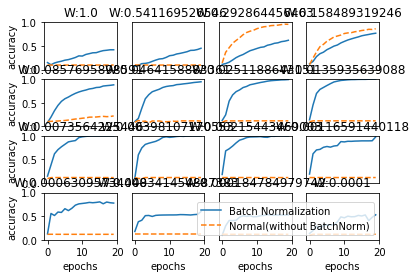

In [121]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

#### 結果の考察
* Batch Normにより，多くの場合で学習が速く進んでいる
* 重みの初期値の与え方により，Batch Normよりも速くなる場合があった
* Batch Normは初期値にそれほど依存しなくて済む（初期値にロバストになる）

## 6.4 正則化
* 機械学習では「過学習(overfitting)」が問題になる
  * 過学習とは，訓練データだけに適応しすぎて汎化性能が得られない状態
* 過学習を抑えるテクニックが必要になる

### 6.4.1 過学習
* 過学習が起きる原因
  * パラメータを大量に持ち，表現力の高いモデルである
  * 訓練データが少ない

epoch:0, train acc:0.156666666667, test acc:0.1588
epoch:1, train acc:0.16, test acc:0.1734
epoch:2, train acc:0.206666666667, test acc:0.1978
epoch:3, train acc:0.243333333333, test acc:0.2275
epoch:4, train acc:0.273333333333, test acc:0.2466
epoch:5, train acc:0.313333333333, test acc:0.2639
epoch:6, train acc:0.333333333333, test acc:0.2803
epoch:7, train acc:0.35, test acc:0.296
epoch:8, train acc:0.4, test acc:0.3089
epoch:9, train acc:0.4, test acc:0.3126
epoch:10, train acc:0.406666666667, test acc:0.3177
epoch:11, train acc:0.41, test acc:0.3227
epoch:12, train acc:0.433333333333, test acc:0.3293
epoch:13, train acc:0.446666666667, test acc:0.3379
epoch:14, train acc:0.443333333333, test acc:0.3395
epoch:15, train acc:0.443333333333, test acc:0.3446
epoch:16, train acc:0.473333333333, test acc:0.3543
epoch:17, train acc:0.46, test acc:0.3574
epoch:18, train acc:0.48, test acc:0.3732
epoch:19, train acc:0.5, test acc:0.3584
epoch:20, train acc:0.51, test acc:0.3461
epoch:21, tr

epoch:169, train acc:0.896666666667, test acc:0.7307
epoch:170, train acc:0.906666666667, test acc:0.7171
epoch:171, train acc:0.903333333333, test acc:0.729
epoch:172, train acc:0.903333333333, test acc:0.729
epoch:173, train acc:0.903333333333, test acc:0.7321
epoch:174, train acc:0.916666666667, test acc:0.7251
epoch:175, train acc:0.906666666667, test acc:0.7256
epoch:176, train acc:0.91, test acc:0.7285
epoch:177, train acc:0.903333333333, test acc:0.7271
epoch:178, train acc:0.913333333333, test acc:0.7266
epoch:179, train acc:0.91, test acc:0.7314
epoch:180, train acc:0.9, test acc:0.7276
epoch:181, train acc:0.91, test acc:0.7297
epoch:182, train acc:0.916666666667, test acc:0.7232
epoch:183, train acc:0.91, test acc:0.7259
epoch:184, train acc:0.913333333333, test acc:0.7271
epoch:185, train acc:0.91, test acc:0.7299
epoch:186, train acc:0.91, test acc:0.7307
epoch:187, train acc:0.906666666667, test acc:0.7316
epoch:188, train acc:0.903333333333, test acc:0.7295
epoch:189, tr

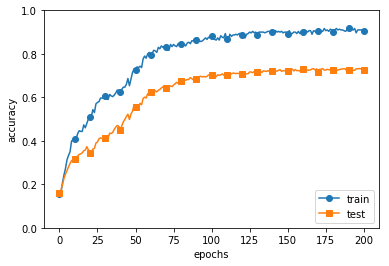

In [122]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 結果の考察
* 訓練データとテストデータとで，結果に大きな隔たりがある
  * 訓練データだけに適応してしまい，訓練時に使用しなかったデータへの対応がうまくできていない

### 6.4.2 Weight decay(荷重減衰)
* 過学習抑制のために用いられる方法
* 考え方：学習過程において，大きな重みを持つことに対し，ペナルティを課す
  * 過学習が大きな重みパラメータの値により発生することがよくある，という経験に基づく

### 6.4.3 Dropout

## 6.5 ハイパーパラメータの検証
### 6.5.1 検証データ
### 6.5.2 ハイパーパラメータの最適化
### 6.5.3 ハイパーパラメータ最適化の実装

## 6.6 まとめ
* やったこと：ニューラルネットワークの学習を行う上で重要ないくつかのテクニック
  * パラメータの更新方法
    * Momentum
    * AdaGrad
    * Adam
  * 重みの初期値の与え方：正しい学習を行う上で非常に重要
    * Xavierの初期値
    * Heの初期値
  * Batch Normalization：学習を速く進め，初期値に対してロバストになる
  * 過学習を抑制するための正則化
    * Weight decay
    * Dropout
  * ハイパーパラメータの探索：良い値が存在する範囲を徐々に絞りながら進めるのが効率良い